In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import cv2
import torch
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import torch.nn as nn
from torchvision.models import resnet101
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
import warnings
import torchinfo
from sklearn.metrics import precision_recall_curve, average_precision_score
import torch.optim as optim

In [14]:
from torchvision import datasets

train_dataset = datasets.ImageFolder(root='datasets/train')
print(train_dataset.class_to_idx)

{'Benign': 0, 'Malignant': 1}


In [15]:
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load dataset
train_dataset = datasets.ImageFolder(root='datasets/train', transform=transform)
test_dataset = datasets.ImageFolder(root='datasets/valid', transform=transform)
print(train_dataset.class_to_idx)
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

{'Benign': 0, 'Malignant': 1}


In [16]:
import torchvision.models as models

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Modify the final layer for your number of classes
num_classes = 2  # This must match the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [19]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    # Wrap the train_loader with tqdm for a progress bar
    train_loop = tqdm(train_loader, desc=f'Train Epoch {epoch+1}', leave=False)
    
    for images, labels in train_loop:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar description with current loss
        train_loop.set_postfix(loss=loss.item())
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1/20


Epoch 1, Loss: 0.4155608117580414
Epoch 2/20


Epoch 2, Loss: 0.3626095652580261
Epoch 3/20


Epoch 3, Loss: 0.19031676650047302
Epoch 4/20


Epoch 4, Loss: 0.3409261107444763
Epoch 5/20


Epoch 5, Loss: 0.12048296630382538
Epoch 6/20


Epoch 6, Loss: 0.3135743737220764
Epoch 7/20


Epoch 7, Loss: 0.5287484526634216
Epoch 8/20


Epoch 8, Loss: 0.3698808550834656
Epoch 9/20


Epoch 9, Loss: 0.22467689216136932
Epoch 10/20


Epoch 10, Loss: 0.12831518054008484
Epoch 11/20


Epoch 11, Loss: 0.19122245907783508
Epoch 12/20


Epoch 12, Loss: 0.13905224204063416
Epoch 13/20


Epoch 13, Loss: 0.002723585581406951
Epoch 14/20


Epoch 14, Loss: 0.008647695183753967
Epoch 15/20


Epoch 15, Loss: 0.03191794455051422
Epoch 16/20


Epoch 16, Loss: 0.2624351382255554
Epoch 17/20


Epoch 17, Loss: 0.003005587961524725
Epoch 18/20


Epoch 18, Loss: 0.001158817787654698
Epoch 19/20


Epoch 19, Loss: 0.3952563405036926
Epoch 20/20


Epoch 20, Loss: 0.022845551371574402


In [21]:
#validate datasets

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total

print(f'Accuracy of the network on the test images: {accuracy:.2f}%')



Accuracy of the network on the test images: 0.89%


In [22]:
# Validation loop with tqdm


model.eval()  # Set model to evaluation mode
val_loop = tqdm(test_loader, desc='Validation', leave=False)
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loop:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar with accuracy
        val_loop.set_postfix(accuracy=100 * correct / total)

print(f'Validation Accuracy: {100 * correct / total}%')

Validation Accuracy: 89.47368421052632%


In [24]:


torch.save(model.state_dict(),'F:\\final_project\skin\skin_cancer_model')

print('Model saved successfully.')

Model saved successfully.


f:\program\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\program\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Ahmed Amr\AppData\Local\Temp\ipykernel_7148\1540238933.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

Malignant


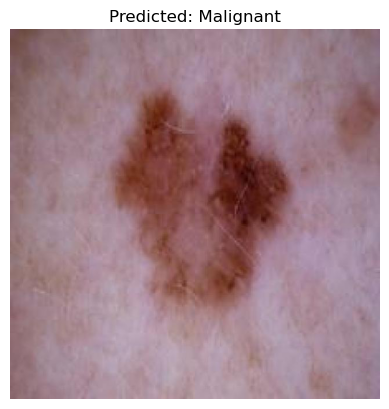

In [43]:
import torch.nn.functional as F
#test the model


model = models.resnet18(pretrained=True)
num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load('F:\\final_project\skin\skin_cancer_model'))

model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

image = Image.open("F:\\final_project\\skin\\datasets\\test\\Malignant\\547_jpg.rf.689a1805d6126484358feab42f78d233.jpg")

image_tensor = transform(image)

image_tensor.unsqueeze_(0)

output = model(image_tensor)

probabilities = F.softmax(output, dim=1)

predicted_class = torch.argmax(probabilities, dim=1)

label = None
if predicted_class.item() ==0:
    label = 'Bengin'
    print("Benign")

else :
    label = 'Malignant'
    print("Malignant")   



#plot the image with the predicted

plt.imshow(image)
plt.title(f'Predicted: {label}')
plt.axis(False)
plt.show()


